# 0. Introduction

NOTE: If you already have sites selected, please skip to part 4 after loading the libraries.

This notebook selects random coordinates within a given shapefile, selects a location of an upstream reach within the NWM hydrofabric, and preprocesses forcings and attribute data at those locations to a csv file ready to upload into a streamflow prediction model.

This notebook is not fully automated. At certain points, it will prompt you to edit cells and asks you to confirm that you have done so correctly. It also requires you to do some GIS work and come back with a csv layer file. At this point, I don't know how to automate it, although that will be a fun project for later.

## 0.1 Load libraries

In [1]:
# load libraries for random coordinate generation

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon
import shutil
import time
import datetime

In [2]:
# load libraries for pair generation
from concurrent.futures import ThreadPoolExecutor
import random

In [3]:
# load libraries for netCDF processing

import multiprocessing as mp
import xarray as xr
import os
import sys
import glob
from exactextract import exact_extract
import warnings

## 0.2 Set up directory for new experiment

In [20]:
# set unique directory name

dir_name = "runs/experiment_" + str(datetime.date.today())
os.mkdir("./"+dir_name)

# 1. Select Random Coordinates

https://stackoverflow.com/questions/74378025/generate-random-coordinates-in-united-states

<Axes: >

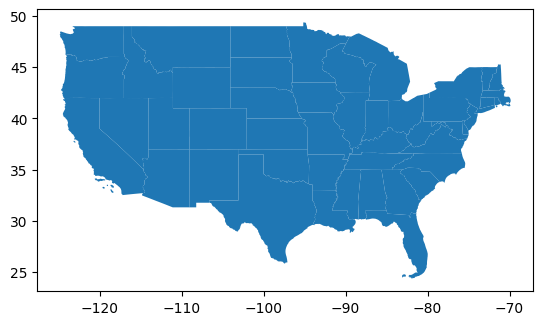

In [20]:
# grab shape within which to sample
path = "shapefiles/tl_2023_us_state/tl_2023_us_state.shp"

# filter out non conus parts
shape = gpd.read_file(path).explode()

conus_bounds = Polygon([(-128, 24), (-128, 55), (-67, 55), (-67, 24), (-128, 24)])

# Filter geometries that fall within the US bounds
shape = shape.loc[shape.geometry.apply(lambda x: x.within(conus_bounds))]
shape.plot()

In [21]:
# grab bounding box within which to generate random numbers
x_min,y_min,x_max,y_max = shape.geometry.unary_union.bounds 

N=10000

# Generate random points within the bounding box
rndn_sample = pd.DataFrame({
    'x': np.random.uniform(x_min, x_max, N),
    'y': np.random.uniform(y_min, y_max, N)
})

# Convert the DataFrame into a GeoDataFrame
rndn_sample_gdf = gpd.GeoDataFrame(rndn_sample, geometry=gpd.points_from_xy(rndn_sample.x, rndn_sample.y), crs=shape.crs)

# Filter points that are within the shape boundary
inshape = rndn_sample_gdf.geometry.apply(lambda s: s.within(shape.geometry.unary_union))

# Keep only the points that are within the shape
rndn_sample_gdf = rndn_sample_gdf.loc[inshape]

/tmp/ipykernel_2953106/1743583958.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  x_min,y_min,x_max,y_max = shape.geometry.unary_union.bounds
/tmp/ipykernel_2953106/1743583958.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  inshape = rndn_sample_gdf.geometry.apply(lambda s: s.within(shape.geometry.unary_union))


<Axes: >

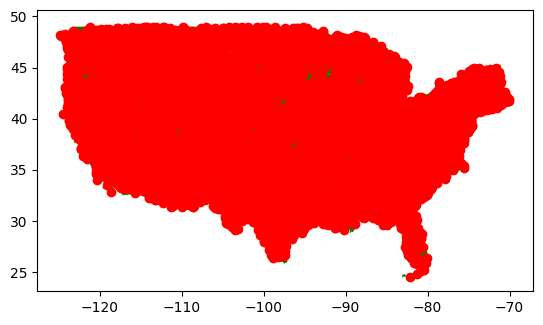

In [22]:
# Plot for visual inspection of the results
ax = shape.plot(color="green")
rndn_sample_gdf.plot(ax=ax, color="red")

In [23]:
# turn GeoDataFrame into pandas DataFrame

rndn_sample = pd.DataFrame(rndn_sample_gdf)

rndn_sample.head()

,x,y,geometry
2,-82.615222,38.298861,POINT (-82.61522 38.29886)
4,-105.770072,37.005390,POINT (-105.77007 37.00539)
5,-82.955601,45.382505,POINT (-82.9556 45.3825)
6,-105.226923,34.926341,POINT (-105.22692 34.92634)
7,-90.335829,41.632636,POINT (-90.33583 41.63264)


In [24]:
# save into csv

rndn_sample.to_csv(os.path.join(dir_name, "sample.csv"), index=False)

In [5]:
starttime = time.time()

In [42]:
check = 'n'

while check != 'y':
    check = input("Have you updated the shell script? (y/n)")

Before executing the following cell, update the shell script. Update the filepath to sample.csv and the desired time period. The following cell uses the ngiab_data_preprocess package to subset and get attributes for each catchment.

In [ ]:
%%sh

chmod +x coords_forcings_atts.sh
cat coords_forcings_atts.sh
./coords_forcings_atts.sh

In [ ]:
endtime = time.time()

# 2. Select Pairs

In [7]:
# create empty csv

with open(os.path.join(dir_name, "catchments.csv"), "w") as cats:
    cats.write('catchment_id,du,x,y\n')

In [46]:
check = 'n' 
while check != 'y':
    check = input("Have you updated the following cell with the path to your ngiab_data_cli output folder? (y/n)")

Before executing the following cell, make sure you have updated the path to your ngiab_data_cli output folder.

In [8]:
ngiab_output_dir = "/media/volume/Imp_Data/quinn_test_atts/ngiab_preprocess_output"

In [12]:
for catid in os.listdir(ngiab_output_dir):

    # ignore all irrelevant dirs or dirs with no upstream catchments

    atts_path = os.path.join(ngiab_output_dir, catid, "config", "cfe_noahowp_attributes.csv")
    if not os.path.exists(atts_path):
        continue

    #if os.path.getmtime(atts_path) < starttime or os.path.getmtime(atts_path) > endtime:
        #continue

    attributes = pd.read_csv(atts_path)
    attributes.set_index("divide_id", inplace=True)

    if len(attributes) == 1:
        continue

    ds_x = attributes.at[catid, "X"]
    ds_y = attributes.at[catid, "Y"]

    #if ds_x > x_max or ds_x < x_min:
       # continue
    #if ds_y > y_max or ds_y < y_min:
       # continue

    ds_input = catid + ",d," + str(ds_x) + "," + str(ds_y) + "\n"

    # select nearby upstream catchment for pairing

    us_id = catid
    attributes.reset_index(inplace=True)

    ds_index = attributes.index[attributes['divide_id']==catid].tolist()[0]

    rand_int = -1

    while us_id == catid:
        if (ds_index-10) < 0:
            leftbound = 0
        else:
            leftbound = ds_index-10

        if (ds_index+10) > len(attributes)-1:
            rightbound = len(attributes)
        else:
            rightbound = ds_index+10

        rand_int = random.randint(leftbound, rightbound-1)

        us_id = attributes.at[rand_int, "divide_id"]

    attributes.set_index("divide_id", inplace=True)
    us_x = attributes.at[us_id, "X"]
    us_y = attributes.at[us_id, "Y"]
    us_input = us_id + ",u," + str(us_x) + "," + str(us_y) + "\n"

    with open(os.path.join(dir_name, "catchments.csv"), "a") as cats:
        cats.write(ds_input)
        cats.write(us_input)


# 3. Connect to COMID (aka reach ID)

In this section, you will have to use your favorite GIS software or R. These are the steps you'll need to complete:

GIS:
- Download the NWM v3 hydrofabric geopackages
- Fix the geometry in the CONUS catchment shapefile
- Upload catchments.csv to project as a point layer
- Select CONUS catchments overlapping points and create new layer from selection
- Join attributes by location
- Polygon ID is the COMID!

R: 
- use the USGS dataRetrieval package to get COMIDs for each catchment

In [54]:
check = 'n'
while check != 'y':
    check = input("Did you complete the tasks above in your GIS/R software? (y/n)")

# 4. Preprocess final csv

Note: Please make sure you have the Lynker NWM hydrofabric downloaded. It can be downloaded [here](https://lynker-spatial.s3-us-west-2.amazonaws.com/hydrofabric/v2.2/conus/conus_nextgen.gpkg). Remember to change the filepath in the appropriate cell below.

In [4]:
# Ignores warnings about CRS mismatch. if we don't do this the notebook blows up and dies

warnings.filterwarnings('ignore')

In [5]:
# Reads information about desired catchments
# change to desired path name
cats_path = 'all_data.csv'

catchments = pd.read_csv(cats_path)
catchments = catchments[:1000]


In [6]:
# generate pair IDs to each upstream/downstream pair of catchments in case data gets shuffled around by accident

pairids = []
for i in range(len(catchments)):
    if i % 2 == 0:
        pairids.append(i / 2)
    else:
        pairids.append((i-1)/2)

catchments['pair_id'] = pairids

In [7]:
# create list of COMIDs

comids = catchments['comid'].tolist()

In [8]:
forc_path = '/media/volume/Imp_Data/FORCING/2008'

ngiab_output_dir = '/media/volume/Imp_Data/quinn_test_atts/ngiab_preprocess_output/'

lst = os.listdir(forc_path)
num_t = len(lst)

# generate path to attribute files for one catchment, as well as CATID
def getclosest_array(i):

    catid = catchments.iat[i, 0]
    #lon = catchments.iat[i, 2]
    #lat = catchments.iat[i, 3]
    
    if catchments.iat[i,1] == 'd':
        attr_path = os.path.join(ngiab_output_dir, catid, 'config', 'cfe_noahowp_attributes.csv') 
    else:
        ds_catid = catchments.iat[i-1,0]
        attr_path = os.path.join(ngiab_output_dir, ds_catid, 'config', 'cfe_noahowp_attributes.csv')
    
    attr_df = pd.read_csv(attr_path)
    attr_df.set_index('divide_id', inplace=True)

    return attr_path, catid

# generates attribute filepaths and CATIDs for all catchments in parallel
def parallel_gca():
    with mp.Pool() as pool:
        result = pool.map(getclosest_array, range(len(catchments)))
    attr_paths, catids = zip(*result)
    return attr_paths, catids

attr_paths, catids = parallel_gca()


In [9]:
# use globbed filepath, opens forcing NC files 

forc_dataset = xr.open_mfdataset("/media/volume/Imp_Data/FORCING/2008/200801*.LDASIN_DOMAIN1")

In [10]:
# get timestamps for all time steps in study period
times = forc_dataset.time.values

# get time strings
time_strs = []
for i in range(len(times)):
    pddt = pd.to_datetime(times[i])
    newstr = pddt.strftime("%Y-%m-%d %H:%M:%S")
    time_strs.append(newstr)

In [11]:
# process CHANNEL ROUTING (CHRTOUT) files, returns df of streamflow values

problem_comids = []

# def nested_multithreading_catchments(id, ds, value_col):
#     df_cat = ds[["time", value_col]].sel(feature_id=id).to_dataframe()
#     return df_cat


# gets all relevant streamflow data from one timestep (one CHRTOUT file)
def process_chrtout_file2(filename, id_list, value_col="streamflow"):
    with xr.open_dataset(filename) as ds:
        df =  ds[["time", value_col]].sel(feature_id=id_list).to_dataframe()
        # with ThreadPoolExecutor(max_workers = 100) as executor:
        #     df_list = list(executor.map(lambda id: nested_multithreading_catchments(id, ds, value_col), id_list))
        # df = pd.concat(df_list)
        return df

# gets all relevant streamflow data from one timestep (one CHRTOUT file)
# def process_chrtout_file(filename, id_list, value_col="streamflow"):
#     with xr.open_dataset(filename) as ds:
#         df_list = []
#         try:
#             for id in id_list:
#                 df_cat = ds[["time", value_col]].sel(feature_id=id).to_dataframe()
#                 df_list.append(df_cat)
#         except:
#             problem_comids.append(id) 
#             print(id, " not found")
#             #id_list.remove[id]

#         df = pd.concat(df_list)
#         return df

# gets all relevant streamflow data from multiple timesteps through parallelization
def get_q(qlat_files, id_list, index_col="feature_id", value_col="streamflow"):

    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.starmap(process_chrtout_file2, [(filename, id_list) for filename in qlat_files])

    frame = pd.concat(results, axis=0, ignore_index=False)

    return frame

In [12]:
# use globbed filepath to generate q_dataset

q_dataset = get_q(glob.glob("/media/volume/Imp_Data/CHRTOUT/2008/200801*.CHRTOUT_DOMAIN1"), comids)
q_dataset.reset_index(inplace=True)


In [13]:
print(q_dataset)

                      time  feature_id  streamflow   latitude   longitude
0      2008-01-05 17:00:00    17743691        0.00  33.929993 -106.508499
1      2008-01-05 17:00:00    17743087        0.00  34.019398 -106.518356
2      2008-01-05 17:00:00    11191143        0.00  40.900303 -116.697739
3      2008-01-05 17:00:00    11191485        0.00  40.783134 -116.710472
4      2008-01-05 17:00:00    12775229        0.00  46.006786 -107.507111
...                    ...         ...         ...        ...         ...
743995 2008-01-29 08:00:00    10092332        0.00  40.823956 -111.476913
743996 2008-01-29 08:00:00    24885175        0.00  42.825626 -119.202232
743997 2008-01-29 08:00:00    24057655        0.00  42.874771 -119.168480
743998 2008-01-29 08:00:00    14299855        0.01  48.297642  -98.577286
743999 2008-01-29 08:00:00    14299773        0.00  48.272110  -98.637207

[744000 rows x 5 columns]


In [16]:
# define column names for final dataset
forcing_vars = ['U2D', 'V2D', 'LWDOWN', 'RAINRATE', 'T2D', 'Q2D', 'PSFC', 'SWDOWN', 'LQFRAC']
colnames = []
ex_attr_df = pd.read_csv(attr_paths[0])
ex_attr_df.set_index('divide_id', inplace=True)
colnames.append("comid")
colnames.append("catid")
colnames.append("du")
colnames.append("pair_id")
for var_name in forcing_vars:
    colnames.append(var_name)
colnames.append("streamflow")
for var_name in ex_attr_df.columns:
    colnames.append(var_name)

In [18]:
# Set up hydrofabric

# change path to your hydrofabric download location
hf_path = '/home/exouser/Downloads/conus_nextgen.gpkg'
hydrofabric = gpd.read_file(hf_path)
#hydrofabric.head()

# reproject to match forcing dataset CRS
hydrofabric = hydrofabric.to_crs("+proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=30.0 +lat_2=60.0 +lat_0=40.0 +lon_0=-97.0 +x_0=0 +y_0=0 +k_0=1.0 +nadgrids=@null +wktext  +no_defs")

In [ ]:
# Collect forcings, attributes, and streamflow data for a catchment at one time step

def process_time(t_str, t, lat, lon, comid, du, pair_id, catid, attr_values):

    # Initialize the row with basic catchment information
    row = [comid, catid, du, pair_id]

    forcing_data = []
    gdf = hydrofabric.loc[hydrofabric['divide_id']==catid]
    for var in forcing_vars:
        raster = forc_dataset.sel(time=t)[var]
        raster = raster.rio.write_crs("+proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=30.0 +lat_2=60.0 +lat_0=40.0 +lon_0=-97.0 +x_0=0 +y_0=0 +k_0=1.0 +nadgrids=@null +wktext  +no_defs")
        zonal_stats = exact_extract(raster, gdf, 'mean', include_cols='divide_id', output='pandas')
        forcing_data.append(zonal_stats['mean'][0])
    # Append forcing data for each variable
    for var_value in forcing_data:
        row.append(var_value)

    # Streamflow data for the given time and comid
    filtered_data = q_dataset[(q_dataset['time']==t) & (q_dataset['feature_id']==comid)]
    streamflow_value = filtered_data['streamflow'].iloc[-1]
    row.append(streamflow_value)
    #print(t)

    # Append attributes (assuming these were preloaded)
    row.extend(attr_values)

    return (t, row)

# Collects forcings, attributes, streamflow data for one catchment over all time steps 

def process_catchment(k):
    df = {}
    lat = catchments['y'][k]
    lon = catchments['x'][k]
    comid = comids[k]
    attr_path = attr_paths[k]
    catid = catchments['catchment_id'][k]
    du = catchments['du'][k]
    pair_id = catchments['pair_id'][k]
    attr_df = pd.read_csv(attr_path)
    attr_df.set_index('divide_id', inplace=True)
    attr_values = attr_df.loc[catid].tolist()

    #print("loaded atts")

    args = [(time_strs[i], times[i], lat, lon, comid, du, pair_id, catid, attr_values)
            for i in range(len(time_strs))]
    
    with mp.Pool(processes=mp.cpu_count) as pool:
        results = pool.starmap(process_time, args)

    #print("finished mp")
    df = {t: row for t, row in results}
    df = pd.DataFrame.from_dict(df, orient='index', columns=colnames)
    return df

In [21]:
# Collects and saves data for all catchments over all timesteps
# Outputs a file that logs errors and progress
import multiprocessing.pool as mp2

output_name = 'output' + datetime.date.today().isoformat() + '.txt'
results = []
args = [i for i in range(len(catchments))]

with mp2.Pool(10) as pool:
    try:
        result = pool.starmap(process_catchment, args)
        results.append(result)
        with open(output_name, 'a') as file:
            toprint = str(i) + ' done\n'
            file.write(toprint)
    except:
        with open(output_name, 'a') as file:
            toprint = str(i) + ' had an error\n'
            file.write(toprint)
try:
    data = pd.concat(results)
    with open(output_name, 'a') as file:
        file.write('df concatenated\n')
except Exception as e:
    with open(output_name, 'a') as file:
        file.write(f"Error: {e}\n")

try:
    data.to_csv('runs/experiment_2025-01-09/jan_data_agg.csv')
    with open(output_name, 'a') as file:
        file.write('saved :D\n')
except Exception as e:
    with open(output_name, 'a') as file:
        file.write(f"Error: {e}\n")

TypeError: '<' not supported between instances of 'method' and 'int'

In [ ]:
# Collects and saves data for all catchments over all timesteps
# Outputs a file that logs errors and progress

output_name = 'output' + datetime.date.today().isoformat() + '.txt'
results = []
for i in range(len(catchments)):
    try:
        result = process_catchment(i)
        results.append(result)
        with open(output_name, 'a') as file:
            toprint = str(i) + ' done\n'
            file.write(toprint)
    except:
        with open(output_name, 'a') as file:
            toprint = str(i) + ' had an error\n'
            file.write(toprint)
        continue

try:
    data = pd.concat(results)
    with open(output_name, 'a') as file:
        file.write('df concatenated\n')
except Exception as e:
    with open(output_name, 'a') as file:
        file.write(f"Error: {e}\n")

try:
    data.to_csv('runs/experiment_2024-10-15/jan_data_agg.csv')
    with open(output_name, 'a') as file:
        file.write('saved :D\n')
except Exception as e:
    with open(output_name, 'a') as file:
        file.write(f"Error: {e}\n")